# Local propagation by linear decoders

by Dennis A. Mertens

## Introduction

Back-propagation is the algorithm typically (if not always) used to train deep neural networks. The process can be explained through the lenses of the signal propagation framework, introduced by [Kohan et al.](https://amassivek.github.io/sigprop). First, an inference signal is sent through the network, carrying information about the input (i.e. some tensor $x$). As this signal travels through, each operation applied to $x$ is recorded in a graph. Once the signal reaches the output of the network (i.e. represented by some tensor $\hat{y}$), depending on the learning approach (e.g. supervised learning, reinforcement learning, etc.) an error feedback is obtained. This feedback tells how far $\hat{y}$ is from the desired target $y$. Then, a second signal is sent back (in the opposite direction), tracing back the steps the inference signal took. The parameters of the network are updated sequentially as the learning signal reaches each one of them. This process goes back and forth multiple times, until a convergence criterion is met. Despite its great success, back-propagation is costly. For instance, keeping track of the operations applied during the inference signal grows with the size of the network. Furthermore, each parameter needs to wait of the learning signal to reach back in order to be updated. It would be more convenient to update each parameter as soon as the learning signal reaches them. A side effect of such possibility is not having to keep track of the whole path from $x$ to $\hat{y}$. For this reason, multiple proposals of alternative optimization procedures exist. Two exampels are one proposed by [Nøkland and Eidnes](https://arxiv.org/abs/1901.06656) and another proposed by [Geoffrey Hinton](https://arxiv.org/abs/2212.13345).

Nøkland and Eidnes demonstrated the performance of an approach in which the learning signal is back-propagated to each layer separately. When the inference signal reaches a layer $i$, they employ a decoder that maps the output space $H_{i}$ of that layer to the output space $Y$ of the network. As a result, each layer gets their own learning signal as soon as the inference signal reaches them. Furthermore, similar proposal also mention the possibility of training each layer in parallel. In other words, layer $i$ can begin learning even if layer $i-1$ is still being updated.

In this work I explore an approach similar to the one proposed by Nøkland and Eidnes. However, the decoder is much simpler, consisting only of a linear projection without bias term to map from $H_{i}$ to $Y$. Intuitively, the linear decoder, being much less powerful than a single layer with a non-linear activation function, should encourage the layer to configure its output space $H_{i}$ so that it is linearly separable. Furthermore, I explore the performance of this approach when each layer is updated one after the other (sequential) and when all layers are updated simultaneously (parallel). Note that in both cases the layers must wait for the inference signal to reach them. The difference is that on the former approach, a layer only begins learning when the preceding one converges. Meanwhile in the latter, all layers learn at the same time.

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Latex
%matplotlib inline
from torch.utils.data import random_split
from torch.optim import Rprop, Adam, RMSprop, SGD
from torch.nn.functional import mse_loss, binary_cross_entropy, \
    normalize, cosine_similarity
from testing_localprop import *

In order to make it easy to extend the repertoire of datasets easily, I employed a standardized approach. All datasets are contained within a dictionary and most of the code in this notebook is prepared to adapt to any selection from this set.

In [2]:
# Display available datasets
for key in datasets:
    print(key)

signed_xor


In order to test the algorithm with a different dataset, simply assign `selected_dataset` to any of the tags printed above. Re-running the block of code bellow will load the dataset and print a small description of the exercise encoded in the dataset.

In [3]:
# Select a dataset generator to run tests on.
selected_dataset = 'signed_xor'
dataset_builder = datasets[selected_dataset]
# NOTE: Some datasets, being synthetic, are
# generated upon calling the function above.
# As a result, re-running this block of code
# may produce completely new data-points.
training_set = dataset_builder[0]()
test_set = dataset_builder[1]()
training_batches = DataLoader(training_set, batch_size=100, shuffle=True)
test_batches = DataLoader(test_set, batch_size=100, shuffle=True)
# Print a description of the dataset (i.e. what the task is).
display.display(Latex(descriptions[selected_dataset]))

<IPython.core.display.Latex object>

If the dataset is 2-dimensional (i.e. $\vec{x} \in \mathbb{R}^2$, then a sample will be displayed bellow.

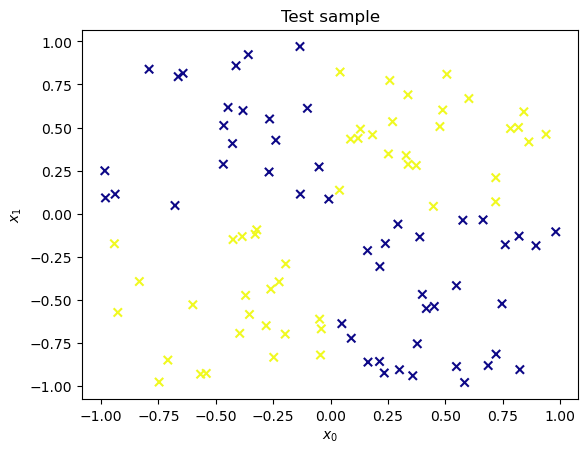

In [4]:
# Colors for plotting decision boundaries and data-points.
high_color = th.tensor([0.97, 0.97, 0.])
low_color = th.tensor([0., 0.25, 0.5])
flag_plot_decision_boundary = False
for X, Y in test_batches:
    # Decide whether the data is 2D, so the model's decision
    # boundary can be plotted.
    flag_plot_decision_boundary = X[0].shape[0] == 2
    # Plot training data.
    if flag_plot_decision_boundary:
        plt.scatter(X[:, 0], X[:, 1], marker='x', c=Y, cmap='plasma')
        # Final touches.
        plt.title('Test sample')
        plt.xlabel(r'$x_0$')
        plt.ylabel(r'$x_1$')
        plt.show()
    # Let's plot only one. No need to see the whole set.
    break

The following block of code defines the architecture of the neural network being tested. Should the selected dataset change the dimensions of $x$ or $y$, the architecture needs to be updated by hand.
> Note: An automated procedure will build a linear decoder for each layer and slice the model in order to isolate each layer from the rest. Beware that the algorithm therefore assumes the model follows a nested structure like the example bellow. Each layer (linear mapping + activation function) is contained within a Sequential object and all layers are contained within a Sequential object.

In [5]:
model = nn.Sequential(nn.Sequential(nn.Linear(2, 100),
                                    nn.Mish(),
                                    LambdaLayer(lambda X: normalize(X))),
                      nn.Sequential(nn.Linear(100, 100),
                                    nn.Mish(),
                                    LambdaLayer(lambda X: normalize(X))),
                      nn.Sequential(nn.Linear(100, 10),
                                    nn.Mish(),
                                    LambdaLayer(lambda X: normalize(X))),
                      nn.Sequential(nn.Linear(10, 1),
                                    nn.Sigmoid()))

In order to test each optimization procedure with the same starting conditions, the initial parameter values of the architecture are stored externally.

In [6]:
th.save(model.state_dict(), 'model_state.pt')

### Back-propagation

Note that, unlike with local-propagation, it is not possible to visualize the hidden representations of each layer, since these lie in dimensions higher than three and, unlike local-propagation, there is no decoder to map them to lower dimensions.

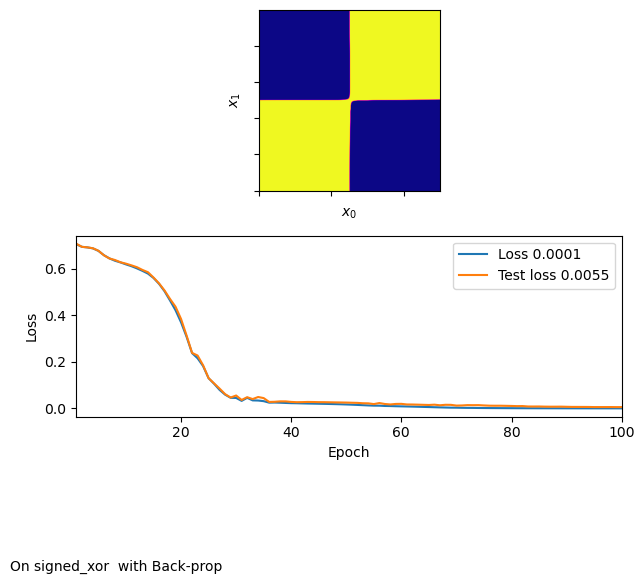

In [7]:
# Load model state from disk.
model.load_state_dict(th.load('model_state.pt'))
# Train with back-propagation.
criterion = binary_cross_entropy
comparator = lambda X, Y: criterion(model(X), Y)
loss_hist = []
# Since the training loss tells us the state of the
# model right before updating the weights,
# the test loss has to tell us the performance right
# before as well.
test_hist = [average_loss(comparator, test_batches)]
EPOCHS = 100
# Note: We are using Rprop, because it is very fast
# and its inherent sensitivity to noise,
# is not a problem here. However, if the data is too
# noisy, it might be a good idea to check
# with a different optimizer. I would suggest Adam.
for epoch, loss in backprop_optimize(model,
                                     Rprop(model.parameters()),
                                     criterion,
                                     EPOCHS,
                                     training_batches):
    loss_hist.append(loss)
    plot_BP_progress(model,
                     epoch,
                     EPOCHS,
                     loss_hist,
                     selected_dataset,
                     test_hist=test_hist,
                     plot_decision_boundary=flag_plot_decision_boundary)
    test_hist.append(average_loss(comparator, test_batches))

### Local-propagation (parallel)

The following block of code trains the same neural network by updating each layer simultaneously. In other words, each layer learns even if the previous layer is still learning.

One can appreciate that most of the time, subsequent layers do not learn useful features, thus getting stuck in shallow minima. Although the connection is not easy to explain mathematically, after comparing the behavior of the parallel approach to the sequential approach, it is clear that there is a link between the noise of the incoming inference signal and the kind of features the subsequent layers can learn.

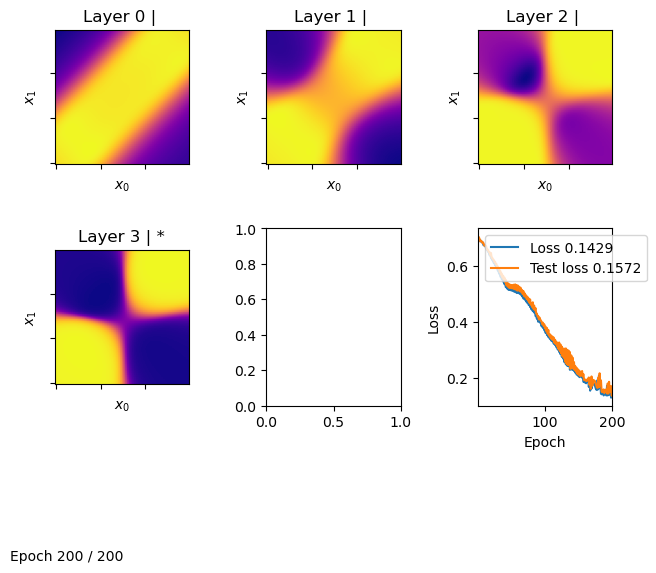

In [10]:
# Load model state from disk.
model.load_state_dict(th.load('model_state.pt'))
# Train with local-propagation (training all layers
# at once).
criterion = binary_cross_entropy
comparator = lambda X, Y: criterion(model(X), Y)
loss_hist = []
# Since the training loss tells us the state of the
# model right before updating the weights,
# the test loss has to tell us the performance right
# before as well.
test_hist = [average_loss(comparator, test_batches)]
EPOCHS = 200
for epoch, loss, encoders, decoders in locally_optimize_parallel(model,
                                                                 Rprop(model.parameters()),
                                                                 mse_loss,
                                                                 binary_cross_entropy,
                                                                 EPOCHS,
                                                                 training_batches):
    loss_hist.append(loss)
    plot_LP_progress(encoders,
                     model,
                     decoders,
                     epoch,
                     EPOCHS,
                     len(model) - 1,
                     loss_hist,
                     test_hist)
    test_hist.append(average_loss(comparator, test_batches))

### Local-propagation (sequential)

When each layer is optimized to convergence sequentially, the refinement of the decision boundary at each layer is more stable. Not only during training, layers tend to stick around configurations that perform well, but the shape of the decision boundary is close to the one obtained with back-propagation.

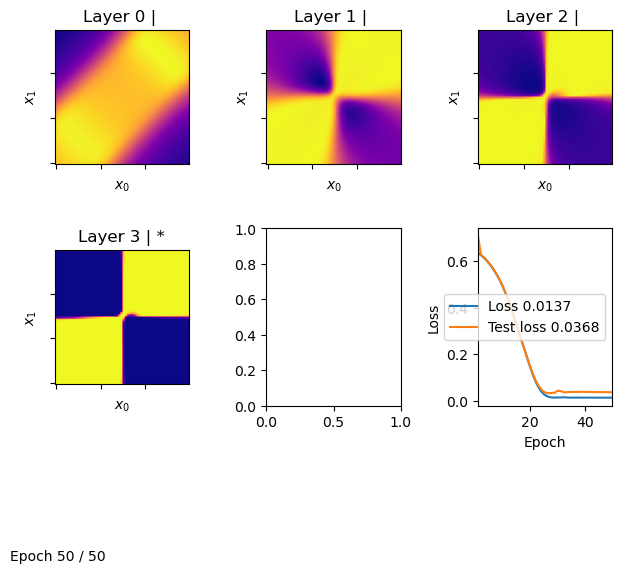

In [9]:
# Load model state from disk.
model.load_state_dict(th.load('model_state.pt'))
# Train with local-propagation (training each
# layer at the time).
criterion = binary_cross_entropy
comparator = lambda X, Y: criterion(model(X), Y)
loss_hist = []
# Since the training loss tells us the state of the
# model right before updating the weights,
# the test loss has to tell us the performance right
# before as well.
test_hist = [average_loss(comparator, test_batches)]
EPOCHS = 50
# Note: We are using Rprop, because it is very fast
# and its inherent sensitivity to noise,
# is not a problem here. However, if the data is too
# noisy, it might be a good idea to check
# with a different optimizer. I would suggest Adam.
for idx, epoch, loss, encoders, decoders in locally_optimize(model,
                                                           Rprop(model.parameters()),
                                                           mse_loss,
                                                           binary_cross_entropy,
                                                           EPOCHS,
                                                           training_batches):
    last_layer = idx + 1 == len(model)
    if last_layer:
        loss_hist.append(loss)
    plot_LP_progress(encoders,
                     model,
                     decoders,
                     epoch,
                     EPOCHS,
                     idx,
                     loss_hist if last_layer else None,
                     test_hist if last_layer else None)
    if last_layer:
        test_hist.append(average_loss(comparator, test_batches))

The difference between the two approaches is, at least at first glance, due to the fact that in the parallel approach, each layer $i$ is trying to map from $H_i$ to $Y$, but samples in $H_i$ are following a moving distribution. I hypothesize that, as a result, layers tend to only learn obvious patterns and ignore finer ones. As finer patterns are (perhaps) more susceptible to these changes.

However, sticking with the sequential approach is not a solution, since it entails trading memory for time. In other words, if we swap back-propagation with sequential local-propagation, we are trading the memory consumed by BP for the time consumed by SLP. So, I insist in finding a way of making the parallel approach work reliably.

I hypothesize that it is possible to find an approach that lies in the middle of the interpolation between the sequential approach and the parallel approach. Note that in back-propagation parameters are updated from last to first (in reverse). This leads to the emergence of an interesting phenomenon: the parameters near the output layer change more than those farther away. This is one of the fundamental motivations for [Echo state networks](https://en.wikipedia.org/wiki/Echo_state_network). This phenomenon must not be confused with [the vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). In the former, parameter updates to layer near the input are small, because they need not be any larger. In local-propagation, it is not possible to know whether an update will have significant impact a posteriori, because there is no learning signal being back-propagated. I instead suggest recreating the same phenomenon in reverse, updating subsequent parameters slowly when needed. Picture a toy example where the input of some layer $i$ is 2-dimensional. The average magnitude of the displacement of the sampled inputs in the training batch is nearly zero along axis 0, but it is large along axis 1. This indicates that patterns present along axis 0 are now stable, so the parameters should be updated accordingly. Meanwhile, these updates should be made so that patterns present in axis 1 are ignored (for the time being). This will prevent the parameters of this layer from learning to be invariant to the features that are yet not stable.